# 強結合モデル（2022年春 Lab1）

```{note}
このNotebookはQiskit v0.44の仕様に合わせてコードを改変しています。
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, transpile, Aer, IBMQ, execute
from qiskit.visualization import *

from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

![](./resources/2022-spring-lab1-tb-model.png)

強結合モデルは、固体材料の中の電子のコンダクタンスを表す量子力学的描像です。このモデルでは、各原子は格子点として扱われ、粒子はその格子点を占有するためにエネルギー$\epsilon_i$が必要です。電子は、格子点から隣の格子点に$J$のエネルギーコストでトンネル移動することができます。以下のハミルトニアンがこのモデルを表しています。

$$H_{\rm tb}/\hbar = \sum_i \epsilon_i Z_i + J \sum_{\langle i,j \rangle} (X_i X_j + Y_i Y_j)$$

ハミルトニアンの最初の項は、各格子点のon-siteエネルギーを表し、二項目は隣り合う格子点同士の相互作用エネルギーを表します。周期格子ポテンシャルがある場合、与えられた量子的粒子の波動関数は隣の格子点にまたがり、拡張的ブロッホ波動関数を導きます。一様な格子の場合、つまり、全ての格子点エネルギーが等しい($\epsilon_i=0$)場合、電子の伝搬は時間に対して線形で、連続な時間の量子ランダムウォークによって表されます。これは、古典的な拡散輸送とは異なり、伝搬が時間に対して2次関数的に遅くなります。

この系のハミルトニアンは、量子状態が時間に対してどのように進化するか記述してくれます。この時間発展は、次のシュレディンガー方程式によって支配されています：

$$ i \hbar \frac{\partial}{\partial t}|\psi(t)\rangle = H |\psi(t)\rangle $$

時間に依存しないハミルトニアンの場合（時間によってハミルトニアンが変化しない場合）、シュレディンガー方程式の解は以下の形になります：

$$ |\psi(t)\rangle = e^{-i H t / \hbar} |\psi(0)\rangle $$

このExerciseでは、強結合ハミルトニアンにおける時間ダイナミクスを学び、その時間発展におけるトロッター回路を構築します。

## 強結合ハミルトニアンにおける時間発展

最初に、3つの格子点を持つ強結合ハミルトニアンにおける時間発展について考えます。ここで$J=1$とし、一様な格子になるように$\epsilon_i=0$とします。

In [2]:
# Import Pauli operators (I, X, Y, Z)
from qiskit.opflow import I, X, Y, Z

J = 1

# tight-binding Hamiltonian
def H_tb():
    # Interactions (I is the identity matrix; X and Y are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    
    # Sum interactions
    H = J*(XXs + YYs)
    
    # Return Hamiltonian
    return H

In [3]:
# Unitary evolution under the tight-binding Hamiltonian
def U_tb(t):
    H = H_tb()
    return (t * H).exp_i()

系を$|100\rangle$に初期化し、状態$|100\rangle, |010\rangle, |001\rangle$の確率の軌跡を出します。　これらの値は、問題としている格子の各格子点における粒子の存在確率に相当します。

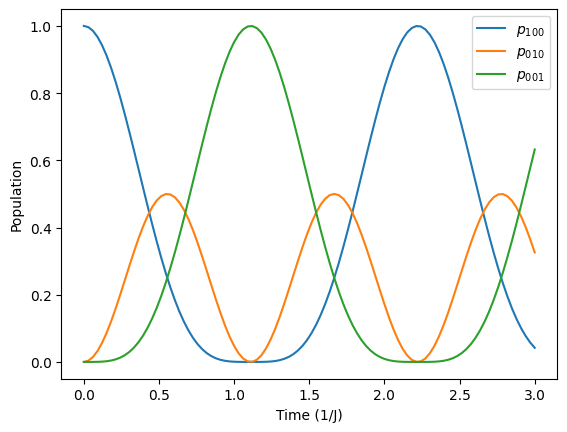

In [4]:
# Import qubit states Zero (|0>) and One (|1>)
from qiskit.opflow import Zero, One

# Define array of time points
ts = np.linspace(0, 3, 100) # DO NOT CHANGE THIS

initial_state=One^Zero^Zero

state_t=[U_tb(float(t)) @ initial_state for t in ts]

p_100= [np.abs( (~(One^Zero^Zero) @ state).eval() )**2 for state in state_t]
p_010= [np.abs( (~(Zero^One^Zero) @ state).eval() )**2 for state in state_t]
p_001= [np.abs( (~(Zero^Zero^One) @ state).eval() )**2 for state in state_t]

plt.figure(facecolor='white')
plt.plot(ts, p_100, label=r'$p_{100}$')
plt.plot(ts, p_010, label=r'$p_{010}$')
plt.plot(ts, p_001, label=r'$p_{001}$')
plt.xlabel(r'Time (1/J)')
plt.ylabel(r'Population')
plt.legend()
plt.show()

## トロッター分解

[circuit model](https://qiskit.org/documentation/apidoc/circuit.html)でユニタリー時間発展を実行するために、$U_{\text{tb}}(t)$を量子コンピューターのネイティブゲートである、1量子ビットゲートと2量子ビットゲートに分解しなければなりません。これを実現する一つの方法は[トロッター分解](https://en.wikipedia.org/wiki/Hamiltonian_simulation#Product_Formulas)です（または鈴木-トロッター分解としても知られています）。

以下に\[1-2\]に述べられているトロッター分解の例の概要を示します。

[パウリ演算子はお互いに交換しない](https://en.wikipedia.org/wiki/Pauli_matrices#Commutation_relations) ので、指数関数$U_{\text{tb}}(t)$は単なる指数関数の積には分解できません。しかし、トロッター分解によって指数関数の積として$U_{\text{tb}}(t)$を近似することができます。3スピンの系に含まれる2スピン-1/2粒子の部分系を考えてみましょう。スピン$i$ と$j$ ($i,j \in \{0,1,2\}$)のハミルトニアンは、$H^{(i,j)}_{\text{tb}} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}$になるでしょう。$U_{\text{tb}}(t)$ をシミュレートしようと思っている合計$N=3$の系において取りうる２つの部分系の項に書き換えると、


$$
U_{\text{tb}}(t) = \exp\left[-i t \left(H^{(0,1)}_{\text{tb}} + H^{(1,2)}_{\text{tb}} \right)\right].
$$

$H^{(0,1)}_{\text{tb}}$ と $H^{(1,2)}_{\text{tb}}$は交換しないので、$U_{\text{tb}}(t) \neq \exp\left(-i t H^{(0,1)}_{\text{tb}}\right) \exp\left(-i t H^{(1,2)}_{\text{tb}} \right)$です。しかし、この積の分解は、$U_{\text{tb}}(t)$が$H^{(0,1)}_{\text{tb}}$の短い時間発展 (time = $t/n$)と$H^{(1,2)}_{\text{tb}}$の短い時間発展 (time = $t/n$)を$n$回繰り返すというトロッター分解によって近似されます。


$$
\begin{align}
U_{\text{tb}}(t) &= \exp\left[-i t \left(H^{(0,1)}_{\text{tb}} + H^{(1,2)}_{\text{tb}} \right)\right] \\
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{tb}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{tb}} \right)\right]^n.
\end{align}
$$

ここで、$n$ はトロッターステップの回数で、$n$が増加するにつれ、その近似は正確になっていきます。(トロッター分解でユニタリー演算が部分系に分割される方法は、必ずしも一意ではないことに注意してください。)分解はさらに進みます。2スピンの部分系において、パウリ演算子のペア($\sigma_x^{(i)}\sigma_x^{(j)}$、$\sigma_y^{(i)}\sigma_y^{(j)}$、$\sigma_z^{(i)}\sigma_z^{(j)}$)は交換可能です。このことは、部分系のハミルトニアン($H^{(i,j)}_{\text{tb}}$) の指数関数を単なる指数関数の積に分解できることを意味し、$U_{\text{tb}}(t)$のゲート実装に近付きます。

$$
\begin{align}
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{tb}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{tb}} \right)\right]^n \\
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} \right)\right) \exp\left(\dfrac{-it}{n}\left(\sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} \right)\right)\right]^{n} \\
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_x^{(1)}\sigma_x^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(1)}\sigma_y^{(2)}\right) \right]^{n}
\end{align}
$$

簡単のために、またより一般的な表記を使うために、積の形式を$XX(2t) = \exp\left(-it \sigma_x\sigma_x\right)$、$YY(2t) = \exp\left(-it \sigma_y\sigma_y\right)$と書き換え、トロッター分解された$U_{\text{tb}}(t)$を書き換えます。

$$
U_{\text{tb}}(t) \approx \left[XX\left(\frac{2t}{n}\right)^{(0,1)} YY\left(\frac{2t}{n}\right)^{(0,1)}  XX\left(\frac{2t}{n}\right)^{(1,2)} YY\left(\frac{2t}{n}\right)^{(1,2)}\right]^{n}
$$
これでできました！$U_{\text{tb}}(t)$の分解のおおよその形を2量子ビットゲートの$XX(t)$ と$YY(t)$で書くことができました。これらのゲートは、超電導量子ビットではネイティブゲートではありませんが、2章でネイティブの１量子ビットゲートと2量子ビットゲートにさらに分解します。*より詳しい解説は補足資料をご覧ください。*


\[1\] Y. Salathe, et al., *Digital Quantum Simulation of Spin Models with Circuit Quantum Electrodynamics*, [Phys. Rev. X **5**, 021027 (2015)](https://link.aps.org/doi/10.1103/PhysRevX.5.021027)

\[2\] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3* 3 (2020)](https://doi.org/10.1002/qute.201900052) \[[free arxiv version](https://arxiv.org/abs/1907.03505)\]


### 個々のパウリのユニタリー演算子の構築

この章では、ZZ(t)、XX(t)、YY(t)演算を１量子ビットゲートと2量子ビットゲートで構築します。

In [5]:
t = Parameter('t')

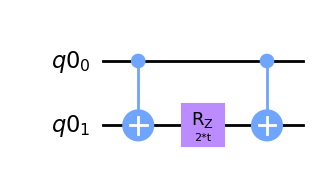

In [6]:
# Build a subcircuit for ZZ(t) from single- and two-qubit gates

ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cnot(0,1)

# Convert custom quantum circuit into a gate
ZZ = ZZ_qc.to_instruction()

ZZ_qc.draw("mpl")

### クリフォードゲート
クリフォードゲートは、パウリ演算子を他のパウリ演算子に変換する量子演算子です。アダマールゲート ($H$) と位相ゲート($S$)は、１量子ビットのクリフォードゲートの例の一部です。

$$H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\1 & -1\\ \end{pmatrix}$$

$HZH^\dagger=X$であり、$HXH^\dagger=Z$です。アダマールゲートは、エルミート演算子なので、$H=H^\dagger$です。

$$S=\begin{pmatrix} 1 & 0 \\0 & i\\ \end{pmatrix}$$

$SXS^\dagger=Y$であり、$SYS^\dagger=-X$です。

クリフォードゲートを使うと、$e^{i ZZ t}$ を$e^{i XX t}$ と$e^{i YY t}$に変換できます。

#### Challenge question 1a

````{admonition} $XX(t)$の構築
XX(t)のための部分回路を１量子ビットゲートと2量子ビットゲートで構築してください。

```python

XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

###EDIT CODE BELOW (add Clifford operator)

###DO NOT EDIT BELOW

XX_qc.append(ZZ, [0,1])

###EDIT CODE BELOW (add Clifford operator)

###DO NOT EDIT BELOW

# Convert custom quantum circuit into a gate
XX = XX_qc.to_instruction()

XX_qc.draw("mpl")
```
````

#### 解答例

In [1]:

XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

###EDIT CODE BELOW (add Clifford operator)

###DO NOT EDIT BELOW

XX_qc.append(ZZ, [0,1])

XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

XX_qc.h([0, 1])
XX_qc.append(ZZ, [0,1])
XX_qc.h([0, 1])

XX = XX_qc.to_instruction()

XX_qc.draw("mpl")

# Convert custom quantum circuit into a gate
XX = XX_qc.to_instruction()

XX_qc.draw("mpl")

NameError: name 'QuantumRegister' is not defined

```{admonition} 解説
:class: tip
$ZZ$ゲート、$XX$ゲートはそれぞれ行列を用いて表すと

$$ZZ = \begin{pmatrix} cos t - i \sin t Z & 0\\  0 & \cos t + i \sin t Z \end{pmatrix},~ XX = \begin{pmatrix} cos t & - i \sin t X \\ - i \sin t X & cos t \end{pmatrix}$$

となります。したがって、$HZH^\dagger=HZH=X$の性質を用いてそれぞれの量子ビットについて$ZZ$ゲートを$H$ゲートで挟むと

$$\frac{1}{2} \begin{pmatrix} H & H\\ H & -H \end{pmatrix} \cdot ZZ \cdot \begin{pmatrix} H & H\\ H & -H \end{pmatrix}
= XX
$$

となり$XX$ゲートが得られます。
```

#### Challenge question 1b

````{admonition} $YY(t)$の構築
YY(t)のための部分回路を１量子ビットゲートと2量子ビットゲートで構築してください。 

```python

YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')

###EDIT CODE BELOW (add Clifford operator)


###DO NOT EDIT BELOW

YY_qc.append(ZZ, [0,1])

###EDIT CODE BELOW (add Clifford operator)


###DO NOT EDIT BELOW

# Convert custom quantum circuit into a gate
YY = YY_qc.to_instruction()

YY_qc.draw("mpl")
```
````

#### 解答例

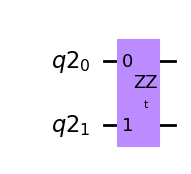

In [8]:
YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')

YY_qc.s([0, 1])

# XXゲート
YY_qc.h([0, 1])
YY_qc.append(ZZ, [0,1])
YY_qc.h([0, 1])

YY_qc.sdg([0, 1])

# Convert custom quantum circuit into a gate
YY = YY_qc.to_instruction()

YY_qc.draw("mpl")

YY_qc.append(ZZ, [0,1])

```{admonition} 解説
:class: tip
Challenge question 1aと同様にして、$SXS^\dagger=Y$の性質を用いてそれぞれの量子ビットについて$XX$ゲートを$S$ゲートと$S^\dagger$で挟むと$YY$ゲートが得られます。
```

### トロッター分解回路の構築


$X_iX_j$演算子と$Y_iY_j$演算子は交換可能です：

$$[X_iX_j, Y_iY_j]= X_iX_j.Y_iY_j - Y_iY_j.X_iX_j = Z_iZ_j-(-Z_i)(-Z_j)=0.$$

したがって、$e^{i t (X_iX_j + Y_iY_j)}$を $e^{i t X_iX_j} e^{i t Y_iY_j}$に分解できます。更に、$i\neq j \neq k \neq l$の場合、$[X_iX_j,X_kX_l]=0$です。このため、トロッター分解の各時間発展を2つのブロックに分解できます。

$$U(\Delta t) \approx \Big(\prod_{i \in \rm{odd}} e^{-i \Delta t X_iX_{i+1}} e^{-i \Delta t Y_iY_{i+1}} \Big)  \Big(\prod_{i \in \rm{even}} e^{-i \Delta t X_iX_{i+1}} e^{-i \Delta t Y_iY_{i+1}} \Big)$$

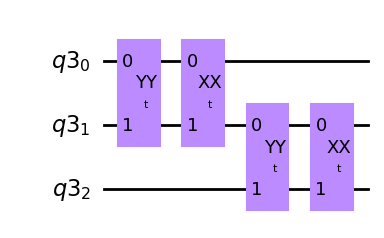

In [9]:
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

for i in range(0, num_qubits - 1):
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

Trot_qc.draw("mpl")

#### Challenge question 1c

````{admonition} トロッター回路の構築
トロッター分解の回路を作成し、その回路に関連付いたユニタリー演算を出力してください。 

```python
def U_trotterize(t_target, trotter_steps):
    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)

    ###EDIT CODE BELOW (Create the trotterized circuit with various number of trotter steps)

    
    ###DO NOT EDIT BELOW
        
    qc = qc.bind_parameters({t: t_target/trotter_steps})
    
    return qi.Operator(qc)
```
````

#### 解答例

In [18]:
def U_trotterize(t_target, trotter_steps):
    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)

    for _ in range(trotter_steps):
        qc.append(Trot_gate, [0, 1, 2])

    qc = qc.bind_parameters({t: t_target/trotter_steps})
    
    return qi.Operator(qc)

```{admonition} 解説
:class: tip
3-qubitの量子回路に対して作成したTrot_gateをtrotter_steps回かけることで求めるユニタリー演算が得られる。
```

```{caution}
下記のコードを実行することで結果の表示が可能ですが、実行に時間がかかるため結果のみ掲載します。
```

In [1]:
"""
実行する場合はコメントを外してください
"""
# t_target = 0.5
# U_target = U_tb(t_target)

# steps=np.arange(1,101,2)  ## DO NOT EDIT

# fidelities=[]

# for n in steps:
#     U_trotter = U_trotterize(t_target, trotter_steps=n)
#     fidelity = qi.process_fidelity(U_trotter, target=U_target)
#     fidelities.append(fidelity)

# plt.figure(facecolor='white')
# plt.loglog(steps, 1-np.array(fidelities))
# plt.ylabel('Trotter error')
# plt.xlabel('Trotter steps')
# plt.show()

'\n実行する場合はコメントを外してください\n'

![](./resources/2022-spring-lab1_trotter.png)